In [1]:
# pytorch를 활용한 딥러닝 활용
import torch # 라이브러리
import torch.nn as nn # 신경망 호출
import torch.optim as optim # 최적화 알고리즘
import torch.nn.init as init # 가중치 초기화
import torch.nn.functional as F # 함수 호출
import torchvision.transforms as transforms # 전처리할 때 사용
import torchvision.datasets as dset # 파이토치 자체 지원 데이터셋 호출

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [16]:
batch_size = 256 # 학습을 할 때 사용할 데이터의 양 설정 - 256
learning_rate = 0.0001 # 학습률 / 값이 높을 수록 학습이 제대로 되지 않음, 너무 낮을 시 과적합 발생
num_epoch = 12 # 학습 횟수

In [17]:
mnist_train = dset.MNIST(root="../", train = True, transform=transforms.ToTensor(),
                         target_transform = None, download = True) # train set
mnist_test = dset.MNIST(root="../", train =False, transform=transforms.ToTensor(),
                        target_transform = None, download = True) # test set

In [18]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__()) # 흑백의 이미지, 1차원 값 사용 / 28*28픽셀, 60000개의 데이터
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000


In [19]:
train_loader = DataLoader(mnist_train,batch_size=batch_size, shuffle=True,
                          num_workers=2,drop_last=True) # 배치 사이즈 선언

test_loader = DataLoader(mnist_test,batch_size=batch_size, shuffle=False,
                         num_workers=2,drop_last=True)

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()


        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(), # 인채널값(흑백) 1, 아웃채널, 커널 사이즈 16 * 24 * 24, 활성화 함수(렐루)
            nn.MaxPool2d(kernel_size=2, stride=2) # 16 * 12 * 12
        )


        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # 32 * 8 * 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 * 4 * 4
        )


        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2), # 64 * 4 * 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 * 2 * 2
        )


        self.fc1 = nn.Linear(256, 100) # 1차원 형태로 컴퓨터에 입력(100개의 벡터 값)
        self.dropout = nn.Dropout(0.3) # 드롭아웃(50%)
        self.fc2 = nn.Linear(100, 10) # 출력값 10


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

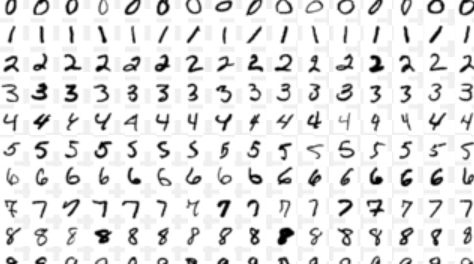

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # gpu설정
print(device)


model = CNN().to(device)

loss_func = nn.CrossEntropyLoss() # 손실함수 지정

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 최적화

cuda:0


In [22]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad() # 각각의 기울기 초기화
        output = model.forward(x) # 예측값 출력
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step() # 가중치

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1664, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward0>)


In [23]:
correct = 0
total = 0


with torch.no_grad(): # 모델 평가를 할 때, 기울기를 비활성화

    for image,label in test_loader:


        x = image.to(device)
        y_= label.to(device)

        output = model.forward(x)

        _,output_index = torch.max(output,1)

        total += label.size(0)

        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 97.18550109863281%


In [24]:
# 과제: 정확도 재설정해보기